In [ ]:
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!pip install -e ARGO_Vision_CODEMOTION_2025
!pip install "git+https://github.com/plana93/sam2.git"
!pip install -q ipympl ipywidgets

fatal: destination path 'ARGO_Vision_CODEMOTION_2025' already exists and is not an empty directory.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for CODEMOTION_2025 (pyproject.toml) ... done
  Created wheel for CODEMOTION_2025: filename=codemotion_2025-0.1.0-0.editable-py3-none-any.whl size=2903 sha256=ea1061d300c4b7d0a1cdc4adf34016459ef181752428a251aab922411c72d9f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-1c4nfxpf/wheels/5b/cb/24/68e4d6865367b2eb40d237767b8b626120727f49411638f36e
Successfully built CODEMOTION_2025
  Attempting uninstall: CODEMOTION_2025
    Found existing installation: CODEMOTION_2025 0.1.0
    Uninstalling CODEMOTION_2025-0.1.0:
      Successfully uninstalled CODEMOTION_2025-0.1.0
  Cloning https://github.com/plana93/sam2.git

In [1]:
import sys
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")

In [2]:
import os
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import numpy as np

from codemotion2025.utils.download_image import download_image_from_url

from sam2.sam2_video_predictor import SAM2VideoPredictor
from sam2.build_sam import build_sam2_video_predictor


In [3]:
######## ALL AUXILIARY FUNCTIONS and CLASS ##########

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def _to_binary_u8(mask, threshold: float = 0.5) -> np.ndarray:
    """
    Convert torch/np mask into (H, W) uint8 in {0, 255}.
    Accepts bool, float, or uint8; handles CUDA tensors.
    """
    # to numpy on CPU
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().squeeze().float().cpu().numpy()
    else:
        mask = np.asarray(mask)
        if mask.ndim > 2:  # drop extra dims if present
            mask = np.squeeze(mask)
        mask = mask.astype(np.float32)

    # sanitize & binarize
    mask = np.nan_to_num(mask, nan=0.0, posinf=1.0, neginf=0.0)
    if mask.dtype == np.bool_:
        bin_u8 = (mask.astype(np.uint8) * 255)
    else:
        # if not already 0/1, threshold
        bin_u8 = ((mask > threshold).astype(np.uint8) * 255)

    return bin_u8

def _save_binary_mask(mask, path, threshold: float = 0.5):
    """
    Save a binary mask to PNG at `path`. Ensures parent dir exists.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    bin_u8 = _to_binary_u8(mask, threshold=threshold)
    Image.fromarray(bin_u8, mode="L").save(path)


class SAM2PredictorWrapper:
    def __init__(self, model_name: str = "sam2-hiera-large"):
        super().__init__()
        self._predictor = SAM2VideoPredictor.from_pretrained(f"facebook/{model_name}")

    @property
    def folder_path(self):
        return self._folder_path

    def get_img_name(self, idx: int) -> str :
        return self._frame_names[idx]


    def reset_state(self):
        self._predictor.reset_state(self._inference_state)
        return self

    def compute_all_sizes(self):
        l_sizes = []
        for f in self._frame_names:
            path_img = Path(self._folder_dir) / f
            l_sizes.append(Image.open(path_img).size)
        return l_sizes

    def preprocess_folder(self):
        l_sizes = self.compute_all_sizes()
        # find the best size and reshape everything mantaining the expect ratio and padding
        best_size = sorted(l_sizes, key=lambda s: s[0] * s[1])[-1]
        for f in self._frame_names:
            path_img = Path(self._folder_dir) / f
            img = Image.open(path_img)
            img = img.resize(best_size)
            img.save(path_img)


    def init_state(self, folder_dir: str, sort: bool = True):
        self._folder_dir = folder_dir
        self._frame_names = [
            p for p in os.listdir(folder_dir)
            if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", ".png", ".bmp"]
        ]

        # self._frame_names = self._frame_names[:100]
        print(f"initialized state with {len(self._frame_names)} frames")

        self.preprocess_folder()

        if sort:
            self._frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

        self._inference_state = self._predictor.init_state(video_path=self._folder_dir)

        return self

    def _show_image(self, frame_idx: int = 0, show_axis: bool = True):
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {frame_idx}")
        plt.imshow(Image.open(os.path.join(self._folder_dir, self._frame_names[frame_idx])))
        if not show_axis:
            plt.axis("off")

    def show_points(self, points, labels, frame_idx: int = 0, show_axis: bool = True):
        points = np.array(points)
        labels = np.array(labels)

        self._show_image(frame_idx, show_axis)
        show_points(points, labels, plt.gca())

    def add_new_points(self, points, labels, obj_ids: list[int], frame_idxs: list[int], show: bool = False):
        for _points, _labels, obj_id, frame_idx in zip(points, labels, obj_ids, frame_idxs):
            self._add_new_points(_points, _labels, obj_id, frame_idx=frame_idx, show=show)

        return self

    def _add_new_points(self, points, labels, obj_id: int = 0, frame_idx: int = 0, show: bool = False):
        points = np.array(points)
        labels = np.array(labels)

        _, out_obj_ids, out_mask_logits = self._predictor.add_new_points_or_box(
            inference_state=self._inference_state,
            frame_idx=frame_idx,
            obj_id=obj_id,
            points=points,
            labels=labels,
        )

        if show:
            self.show_points(points, labels, frame_idx)
            show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

        return self

    def propagate_in_video(self, show_every_n_frames: int = 0, plot:bool = True, save_masks: bool = False):
        # run propagation throughout the video and collect the results in a dict
        video_segments = {}  # video_segments contains the per-frame segmentation results
        for out_frame_idx, out_obj_ids, out_mask_logits in self._predictor.propagate_in_video(self._inference_state):
            # print("--> ", out_frame_idx)
            video_segments[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }

        # render the segmentation results every few frames
        if show_every_n_frames > 0 and plot:
            plt.close("all")
            for out_frame_idx in range(0, len(self._frame_names), show_every_n_frames):
                if out_frame_idx not in video_segments:
                    continue
                self._show_image(out_frame_idx)
                for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                    show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

        if save_masks:
            masks_dir = Path(self._folder_dir) / "masks"
            masks_dir.mkdir(parents=True, exist_ok=True)

            for out_frame_idx in range(0, len(self._frame_names), show_every_n_frames):
                try:
                    out_mask = video_segments[out_frame_idx][1]
                    path_out = masks_dir / f"mask_{self._frame_names[out_frame_idx]}"
                    _save_binary_mask(out_mask, path_out, threshold=0.5)
                except:
                    continue

        return self

In [20]:
test_image = download_image_from_url()
if test_image and os.path.exists(test_image):
    print(f"Using image file at: {test_image}")
else:
    print("No valid image file is available.")

Enter the URL of an online image (or leave blank to use Colab upload): https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7mMm_YqRXkwhMV2mIwJRX3I9ld5fYtgBW9w&s
Downloaded and saved image as: downloads/img_0003.jpg
Using image file at: downloads/img_0003.jpg


In [14]:
## CONFIGURATION
path_dataset = Path(test_image).parent
idx_img = 0
frame_offset = 1
num_repetition_first_frame = 1


In [23]:
m = SAM2PredictorWrapper().init_state(str(path_dataset), sort=False)
image_name = m.get_img_name(idx=idx_img)
image_complete_path = Path(path_dataset) / image_name
img = Image.open(image_complete_path).convert("RGB")

initialized state with 4 frames
False True


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


In [24]:

import matplotlib
print(matplotlib.get_backend())

module://ipympl.backend_nbagg


In [25]:
from google.colab import output
output.enable_custom_widget_manager()

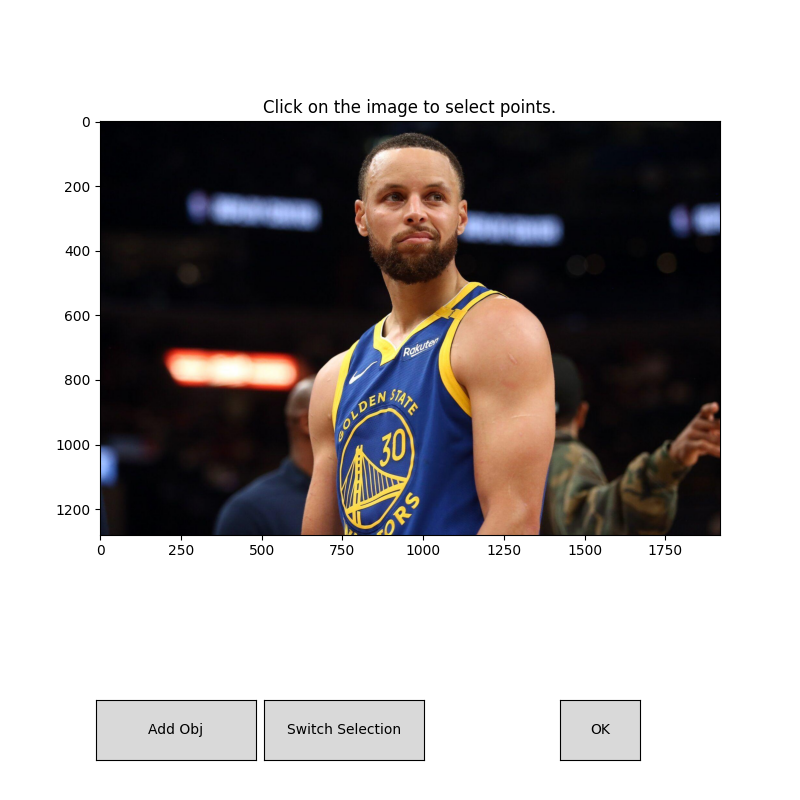

Oggetto 1 salvato con 6 punti.

--- RESULTS ---
Obj 1 -> [[996, 1057], [1253, 896], [804, 1184], [690, 846], [1002, 561], [993, 152]]

 Frame Annotated
Obj 1 -> [[996, 1057], [1253, 896], [804, 1184], [690, 846], [1002, 561], [993, 152]]


In [18]:


%matplotlib widget

points = []
obj_ids = []
label = []
l_obj_ids = []

current_points = []

select_positive = True

def onclick(event):
    if event.inaxes == ax_img:  # click dentro l'immagine
        x, y = int(event.xdata), int(event.ydata)
        current_points.append([x, y])
        cmap = plt.get_cmap("tab10")  # choose a colormap
        color = cmap(len(obj_ids))
        ax_img.scatter(x, y, color=color)
        fig.canvas.draw()

def on_toggle(event):
    global select_positive
    select_positive = not select_positive
    mode = "Positive" if select_positive else "Negative"
    print(f"Switched to {mode} point selection.")

def add_obj(event):
    global current_points
    if current_points:
        points.append(current_points.copy())
        obj_ids.append(len(obj_ids) + 1)
        print(f"Oggetto {obj_ids[-1]} salvato con {len(current_points)} punti.")
        current_points = []  # reset buffer for new obj
    else:
        print("Nessun punto selezionato per questo oggetto!")

def on_ok(event):
    """Conferma selezione e stampa risultato finale."""
    if current_points:
        add_obj(None)

    if not points:
        print("Nessun oggetto creato! Seleziona punti e premi Add Obj.")
        return

    print("\n--- RESULTS ---")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")

    fig.canvas.mpl_disconnect(cid_click)
    plt.close(fig)
    print("\n Frame Annotated")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")
        l_obj_ids.append(obj_ids[i])
        label.append([1]*len(obj))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.subplots_adjust(bottom=0.3)

ax_img = ax
ax_img.imshow(img)
ax_img.set_title("Click on the image to select points.")

ax_ok = plt.axes([0.7, 0.05, 0.1, 0.075])
ax_toggle = plt.axes([0.33, 0.05, 0.2, 0.075])
ax_add_obj = plt.axes([0.12, 0.05, 0.2, 0.075])

btn_ok = Button(ax_ok, 'OK')
btn_toggle = Button(ax_toggle, 'Switch Selection') # negative not used for now
btn_add_obj = Button(ax_add_obj, 'Add Obj')

# Eventi
cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
btn_ok.on_clicked(on_ok)
btn_toggle.on_clicked(on_toggle) # negative not used for now
btn_add_obj.on_clicked(add_obj)

plt.show()






In [26]:
m = m.reset_state()

for _ in range(num_repetition_first_frame):
    m = m.add_new_points(
        points=points,
        labels=label,
        obj_ids=l_obj_ids,
        frame_idxs=[idx_img]*len(l_obj_ids),
        show=False,
)
m = m.propagate_in_video(frame_offset, plot = False, save_masks=True)

propagate in video: 100%|██████████| 4/4 [02:20<00:00, 35.23s/it]
/tmp/ipython-input-1142135492.py:59: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(bin_u8, mode="L").save(path)
